# Topic Modelling - Notes and Playground
(July 06, 2019)

Instead of creating a formal Lit. Review, I would like to learn as much as needed to apply high level concepts for topic modelling. This will start by digging into blogs which utilize standard Python libraries and then push into more in-depth articles, papers, etc. regarding better implementation.

## Table of Contents

1. ["Applying Machine Learning to Classify an Unsupervised Text Documents"](#1)
    * Data -> TD-IDF -> K-means
    
2. ["pyLDAvis - Library for Interactive Topic Model Visualization"](#2)
    * Port of an R package
    
3. ["LDA in Python - How to Grid Search Best Topic Models"](#3)

4. ["Unsupervised LDA to Semi-Supervised GuidedLDA"](#4)

5. [""](#5)

6. ["Playground"](#6)

## Import Libraries and Data

In [1]:
# Imports

# Standard Libraries
from itertools import combinations

# Numerical Libraries
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Visual Libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import Image

# Local Package Libraries
import sys
sys.path.append("../..")

from src.data.make_dataset import *
from src.features.general_helper_functions import *
from src.features.text_cleaning import *

In [2]:
# Settings

# Stop the warnings for chain in pandas...
pd.options.mode.chained_assignment = None

pd.set_option('display.max_colwidth', 1000)

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

%matplotlib inline

In [3]:
# raw data import
_, watchlist_raw, stock_prices_raw = get_raw_data()
article_raw = clean_and_open_business_wire_data_01(None)

In [4]:
# Base data cleaning and formatting
articles = article_raw.copy()
articles.reset_index(inplace=True)
articles.time = pd.to_datetime(articles.time)

watchlist = watchlist_raw.copy()

<a id="1"></a>
## Applying Machine Learning to Classify an Unsupervised Text Documents

* Author builds a model to classify a data set into 2 classifications.
* Steps:
    1. Vectorize the text data by using sklearn's TfidfVectorizer
    2. Implements sklearn's KMeans cluster algorithm with true_k = 2
* The input document is a list of strings, by the appearance the strings are already relatively clean.

In [5]:
# Import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [6]:
titles_cleaned = clean_text(articles, "title").title.values

In [7]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(titles_cleaned)

print(X.shape)

(8433, 8799)


In [8]:
true_num_topics=3 # Obviously not true, but I will go with it for now

naive_kmeans_topic_model = KMeans(
    n_clusters=true_num_topics, 
    init="k-means++", 
    max_iter=100, 
    n_init=1)

naive_kmeans_topic_model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Can now take a look at the top words in each centroid:

In [9]:
order_centroids = naive_kmeans_topic_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_num_topics):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("\n")

Cluster 0:
 announce
 investor
 conference
 present
 healthcare
 pharmaceutical
 board
 therapeutic
 annual
 director


Cluster 1:
 market
 researchandmarkets
 com
 global
 pipeline
 research
 review
 forecast
 analysis
 drug


Cluster 2:
 quarter
 result
 financial
 report
 fourth
 year
 second
 announce
 fiscal
 pharmaceutical




<a id="2"></a>
## pyLDAvis - Library for Interactive Topic Model Visualization
https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=1&lambda=0.5&term=

pyLDAvis is a library that ports an R script for topic visualization.

It is possible to oberlay it with gensim and sklearn.

**pyLDAvis**
https://pyldavis.readthedocs.io/en/latest/

**Gensim's LDA**
https://radimrehurek.com/gensim/models/ldamodel.html

In [8]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.tfidfmodel import TfidfModel
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [9]:
tokenized_titles_cleaned = [remove_short_words(text).split(" ") for text in titles_cleaned]
dictionary = corpora.Dictionary(tokenized_titles_cleaned)
dictionary.filter_extremes(no_below=5, no_above=0.4)

In [10]:
corpus = [dictionary.doc2bow(text) for text in tokenized_titles_cleaned]

In [11]:
tfidf_corpus = TfidfModel(corpus)[corpus]

In [12]:
lda = LdaModel(tfidf_corpus, num_topics=40)

In [15]:
for topic_id in range(4):
    print("Topic:", topic_id)
    print([(dictionary[item[0]], np.round(item[1],3)) for item in lda.get_topic_terms(topic_id)], "\n")

Topic: 0
[('life', 0.094), ('science', 0.088), ('celebrate', 0.046), ('launch', 0.034), ('hypertension', 0.029), ('arterial', 0.029), ('pulmonary', 0.026), ('beam', 0.023), ('strengthen', 0.022), ('university', 0.022)] 

Topic: 1
[('year', 0.065), ('fourth', 0.056), ('result', 0.053), ('quarter', 0.053), ('full', 0.047), ('financial', 0.042), ('dystrophy', 0.04), ('muscular', 0.037), ('call', 0.033), ('report', 0.03)] 

Topic: 2
[('diagnostics', 0.064), ('molecular', 0.05), ('previously', 0.047), ('infectious', 0.041), ('strategy', 0.038), ('guide', 0.031), ('leader', 0.03), ('oncology', 0.03), ('researchandmarkets', 0.026), ('global', 0.026)] 

Topic: 3
[('insight', 0.051), ('name', 0.041), ('agreement', 0.04), ('generation', 0.034), ('sequence', 0.032), ('pipeline', 0.031), ('license', 0.03), ('researchandmarkets', 0.03), ('next', 0.029), ('european', 0.028)] 



In [13]:
pyLDAvis.gensim.prepare(lda, tfidf_corpus, dictionary)

c:\users\michael\documents\projects and portfolio work\biopharmaceuticalfactormodel\venv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.145057  0.016612       1        1  4.834666
20    -0.199299 -0.013308       2        1  3.979597
27    -0.209887 -0.017859       3        1  3.486433
29    -0.192395 -0.027965       4        1  3.245063
5      0.141039  0.259784       5        1  3.140583
15     0.086845 -0.045151       6        1  2.945106
10     0.141822 -0.155180       7        1  2.838599
19    -0.106263  0.047196       8        1  2.784434
31     0.045572 -0.042379       9        1  2.743544
3     -0.126793 -0.013691      10        1  2.715599
1      0.189210 -0.170754      11        1  2.709132
4      0.131511  0.137474      12        1  2.597458
21     0.053325 -0.017854      13        1  2.518127
26    -0.105525 -0.001407      14        1  2.492375
9      0.058773 -0.047122      15        1  2.481640
32     0.159958 -0.193329      16        1  2.471990
2     -0.086622 -0.012439      17        1  2.460293
36    -0.091308 -0.033120      18        1  2.431709
39    -0.024878 -0.036315      19        1  2.430922
17     0.049829  0.158561      20        1  2.416550
6     -0.106059 -0.055352      21        1  2.398760
23     0.065978  0.184163      22        1  2.391955
24    -0.043452 -0.000190      23        1  2.390729
8      0.116290 -0.171786      24        1  2.380479
35    -0.103900 -0.046846      25        1  2.327824
33    -0.004636  0.155386      26        1  2.325901
28     0.134625  0.184070      27        1  2.211408
37    -0.071821 -0.024103      28        1  2.209456
38     0.046768 -0.131028      29        1  2.166589
34    -0.002509 -0.031099      30        1  2.160236
12    -0.026591  0.032814      31        1  2.058504
11     0.076405  0.113299      32        1  2.056616
0     -0.038213 -0.040202      33        1  2.044191
14     0.029322  0.014603      34        1  1.977696
30    -0.028631  0.031076      35        1  1.977599
25     0.145281 -0.031747      36        1  1.940492
22     0.169976 -0.035019      37        1  1.909798
7      0.031595  0.043002      38        1  1.859562
13    -0.080772 -0.002982      39        1  1.818715
16    -0.079513  0.020185      40        1  1.669662, topic_info=     Category        Freq                Term       Total  loglift  logprob
46    Default  157.000000             quarter  157.000000  30.0000  30.0000
16    Default  174.000000             results  174.000000  29.0000  29.0000
44    Default  135.000000           financial  135.000000  28.0000  28.0000
47    Default  111.000000             reports  111.000000  27.0000  27.0000
177   Default   88.000000                firm   88.000000  26.0000  26.0000
320   Default   81.000000             insight   81.000000  25.0000  25.0000
51    Default   83.000000               board   83.000000  24.0000  24.0000
92    Default   81.000000                year   81.000000  23.0000  23.0000
160   Default  102.000000           investors  102.000000  22.0000  22.0000
745   Default   45.000000               ipsen   45.000000  21.0000  21.0000
314   Default   60.000000                life   60.000000  20.0000  20.0000
52    Default   70.000000           directors   70.000000  19.0000  19.0000
90    Default   60.000000              fourth   60.000000  18.0000  18.0000
45    Default   95.000000               first   95.000000  17.0000  17.0000
212   Default   89.000000            investor   89.000000  16.0000  16.0000
933   Default   47.000000             imaging   47.000000  15.0000  15.0000
315   Default   60.000000            sciences   60.000000  14.0000  14.0000
41    Default  236.000000            pipeline  236.000000  13.0000  13.0000
269   Default   70.000000       investigation   70.000000  12.0000  12.0000
2     Default  112.000000          conference  112.000000  11.0000  11.0000
70    Default   68.000000             officer   68.000000  10.0000  10.0000
202   Default   57.000000              behalf   57.000000  

<a id="3"></a>
## LDA Python - How to Grid Search Best Topic Models

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

<a id="4"></a>
## Unsupervised LDA to Semi-Supervised GuidedLDA

https://www.freecodecamp.org/news/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164/

## Topic Modelling Metrics

### Cluster Analysis
https://en.wikipedia.org/wiki/Cluster_analysis

#### Internal Evaluation
* Evaluation based on the data that was clustered itself
* Score high when there is high similarity within a cluster and low similarity between clusters
* Drawbacks:
    * High score on an internal measure do not necessarily result in effective information retrieval applications
    * Evaluation is biased toward algos that use the same cluster model

Note: LDA is technically not a clustering algorithm. It instead uses probability distributions. BUT as seen in the LDA visualization above, we can technically consider there to be clusters too. The definition of different clusters simply needs to be made discreet.

**SKlearn has various metrics for clustering algorithms.**

What we would be looking for are the unsupervised metrics such as:
* Silhouette Coefficient
    * best value is 1, worst is -1. 0 implies overlapping clusters
    * sklearn.metrics.silhouette_score(X(nsamples, nfeatures), labels)
* Calinski-Harabasz Index
    * Larger score is better
    * sklearn.metrics.calinski_harabasz_score(X(nsamples, nfeatures), labels)
* Davis-Bouldin Index
    * 0 is the lowest and best score. Closer to zero, the better
    * sklearn.metrics.davies_bouldin_score(X(nsamples, nfeatures), labels)

### Determining the Number of Clusters

https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

* Rate Distortion Theory

<a id="6"></a>
## Playground

In [12]:
from sklearn.metrics import *
import operator

### Finding the Best Number of Topics

For each of the SKLearn internal clustering metrics, I will try to find the "best" number of topics. Then, using that number, apply LDA to get the topic probabilities. Lastly, manually check some random articles to see how the model does.

To use SKLearn's silhouette_avg, need to predict the labels associated for each document. The classification vector goes in as the "label" input and the data goes in as the X.

In [13]:
def get_best_labels(model, corp):
    return [np.array([tuple_[1] for tuple_ in model.get_document_topics(doc)]).argmax() for doc in corp]

In [19]:
# Settings
max_N = 30
min_N = 3

# Initialize result holder
sill_results = {"best_model": None, "best_model_n": None, "best_score": -1.0}
cal_har_results = {"best_model": None, "best_model_n": None, "best_score": -np.inf}
dav_bou_results = {"best_model": None, "best_model_n": None, "best_score": np.inf}

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    sil_score = silhouette_score(X, best_labels)
    if sil_score > sill_results["best_score"]:
        sill_results["best_model"] = lda_n
        sill_results["best_model_n"] = model_n
        sill_results["best_score"] = sil_score
        
    cal_score = calinski_harabasz_score(X, best_labels)
    if cal_score > cal_har_results["best_score"]:
        cal_har_results["best_model"] = lda_n
        cal_har_results["best_model_n"] = model_n
        cal_har_results["best_score"] = cal_score
        
    dav_score = davies_bouldin_score(X, best_labels)
    if dav_score < dav_bou_results["best_score"]:
        dav_bou_results["best_model"] = lda_n
        dav_bou_results["best_model_n"] = model_n
        dav_bou_results["best_score"] = dav_score

KeyboardInterrupt: 

In [ ]:
print(sill_results)
print(cal_har_results)
print(dav_bou_results)

In [14]:
class NumTopicsScoreHolder:
    def __init__(self, metric_func, score_relation_direction=">"):
        self.metric_func = metric_func
        self.score_function = {">": operator.gt, "<": operator.lt}[score_relation_direction]
        
        self.score_df = pd.DataFrame(columns=["score", "model"])
        
    def update(self, X, model, n, labels):
        self.score_df = pd.concat([self.score_df, pd.DataFrame({"score": self.metric_func(X, labels), "model": model}, index=[n])])
        
    def get_best_model(self):
        indx = {operator.gt: 0, operator.lt: -1}[self.score_function]
        return self.score_df.sort_values("score", ascending=False).iloc[indx].model

In [17]:
# Settings
max_N = 10
min_N = 2

# Initialize result holder
sill_results = NumTopicsScoreHolder(silhouette_score, ">")
cal_har_results = NumTopicsScoreHolder(calinski_harabasz_score, ">")
dav_bou_results = NumTopicsScoreHolder(davies_bouldin_score, "<")

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    sill_results.update(X, lda_n, model_n, best_labels)
    cal_har_results.update(X, lda_n, model_n, best_labels)
    dav_bou_results.update(X, lda_n, model_n, best_labels)

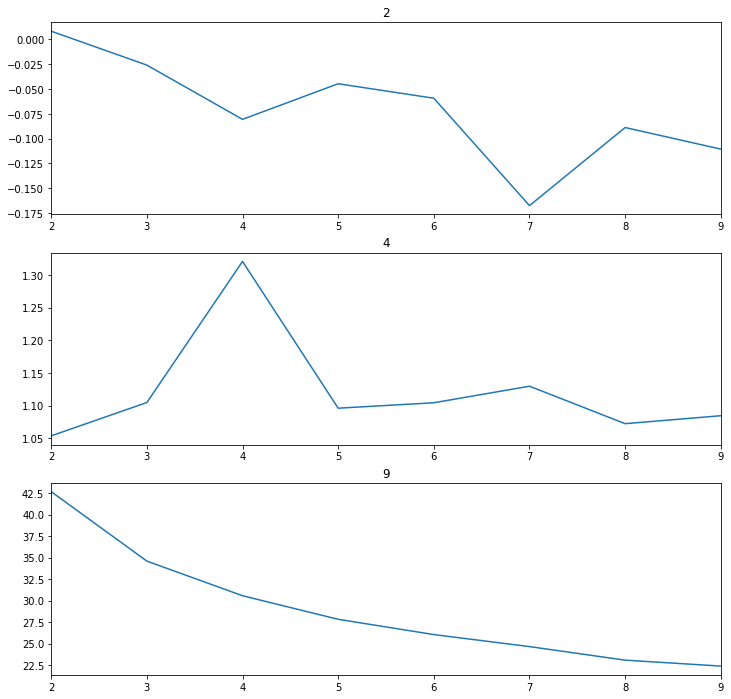

In [18]:
fig, ax = plt.subplots(3, figsize=(12, 12))

ax[0].set_title(sill_results.get_best_model().num_topics)
sill_results.score_df.score.plot(ax=ax[0])

ax[1].set_title(cal_har_results.get_best_model().num_topics)
cal_har_results.score_df.score.plot(ax=ax[1])

ax[2].set_title(dav_bou_results.get_best_model().num_topics)
dav_bou_results.score_df.score.plot(ax=ax[2])

From here, I would like to start taking a look at price statistics for each topic.

To do so I will need to:
1. Seperate the articles into their respective predicted labels
2. Using functionality from previous notebooks, get the window of prices after each event
3. Apply a set of statistics on the prices, and their returns over the window

In [15]:
# Clean price data and get the returns window
prices_df = clean_and_format_prices(stock_prices_raw, articles.ticker.unique())

# Return Window
return_window = compute_return_window(articles, prices_df, n_window=30)

return_window.sort_index().head()

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,...,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_29,R_30
0,0.016568,-0.017357,0.019329,0.012229,0.010651,0.008679,0.011045,-0.042998,0.002761,0.022880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.010794,-0.035081,-0.065921,-0.015420,-0.030840,-0.023130,0.000771,0.007710,-0.052043,-0.040093,...,-0.064765,-0.020046,-0.000386,0.026214,-0.008096,0.002313,NaN,NaN,NaN,NaN
3,0.013173,0.006587,0.001162,-0.045719,-0.008136,0.005037,-0.005812,-0.030221,-0.061217,-0.010461,...,-0.034870,0.001162,-0.005812,-0.007361,-0.009299,-0.006974,-0.060054,-0.015110,0.004649,0.031383
4,0.040000,0.050588,0.012157,0.025490,0.018824,0.013333,-0.034118,0.003922,0.017255,0.006275,...,-0.043529,-0.005882,0.010588,-0.023137,0.013333,0.006275,0.004706,0.002745,0.005098,-0.048627


In [16]:
def sharpe_ratio(mean, dev, holding_period, annual_risk_free_rate):
    scale_param = 252 / holding_period # This will be used to annualize the expected return 
                                       # and the deviation
    num = (scale_param * mean - annual_risk_free_rate) 
    den = (np.sqrt(scale_param) * dev)
    return num / den


def downside_deviation(series):
    mean = series.mean()
    shifted_series = series - mean
    neg_values = shifted_series.loc[shifted_series < 0]
    neg_var = (neg_values ** 2).sum() / neg_values.shape[0]
    return np.sqrt(neg_var)


def sortino_ratio(series, holding_period, annual_risk_free_rate):
    scale_param = 252 / holding_period # This will be used to annualize the expected return 
                                       # and the deviation
    num = (scale_param * series.mean() - annual_risk_free_rate) 
    den = (np.sqrt(scale_param) * downside_deviation(series))
    return num / den
    

def report_statistics(series):
    risk_free_rate  = 0.025
    num_days = 30
    
    mean = np.mean(series)
    dev = np.std(series)
    downside_dev = downside_deviation(series)
    skew_ = skew(series)
    kurt_ = kurtosis(series)
    
    sharpe_ratio_ = sharpe_ratio(mean, dev, num_days, risk_free_rate)
    sortino_ratio_ = sortino_ratio(series, num_days, risk_free_rate)
    
    print_statement = """
    STATISTICAL REPORT:
        If held for {} days, the returns for the topic had the following statistics:
        * mean = {}
        * standard deviation = {}
        * downside deviation = {}
        * skew = {}
        * kurtosis = {}
        
        Sharpe Ratio = {}
        Sortino Ratio = {}
    """. format(np.round(num_days, 4), np.round(mean, 4), np.round(dev, 4), np.round(downside_dev, 4), np.round(skew_, 4),
                np.round(kurt_, 4), np.round(sharpe_ratio_, 4), np.round(sortino_ratio_, 4))
    
    return print_statement

**Best Model Using the Sillhouette Coefficient**

In [21]:
sill_article_df = articles.copy()

sill_article_df["labels"] = get_best_labels(sill_results.get_best_model(), tfidf_corpus)

for topic in range(sill_results.get_best_model().num_topics):
    
    articles_in_topic = sill_article_df.loc[sill_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0194
        * standard deviation = 0.2049
        * downside deviation = 0.1694
        * skew = 1.4682
        * kurtosis = 8.3624
        
        Sharpe Ratio = 0.2326
        Sortino Ratio = 0.2813
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0213
        * standard deviation = 0.2262
        * downside deviation = 0.1744
        * skew = 1.9632
        * kurtosis = 10.8375
        
        Sharpe Ratio = 0.2347
        Sortino Ratio = 0.3044
    





In [22]:
ch_article_df = articles.copy()

ch_article_df["labels"] = get_best_labels(cal_har_results.get_best_model(), tfidf_corpus)

for topic in range(cal_har_results.get_best_model().num_topics):
    
    articles_in_topic = ch_article_df.loc[ch_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0179
        * standard deviation = 0.2106
        * downside deviation = 0.1746
        * skew = 1.4897
        * kurtosis = 8.6192
        
        Sharpe Ratio = 0.2048
        Sortino Ratio = 0.2471
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0218
        * standard deviation = 0.2275
        * downside deviation = 0.1775
        * skew = 1.8197
        * kurtosis = 9.3734
        
        Sharpe Ratio = 0.2398
        Sortino Ratio = 0.3073
    



Topic 2 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0225
        * standard deviation = 0.2096
        * downside deviat

In [23]:
db_article_df = articles.copy()

db_article_df["labels"] = get_best_labels(dav_bou_results.get_best_model(), tfidf_corpus)

for topic in range(dav_bou_results.get_best_model().num_topics):
    
    articles_in_topic = db_article_df.loc[db_article_df.labels == topic]
    
    returns_in_topic = return_window.loc[articles_in_topic.index].dropna()
    
    statement = report_statistics(returns_in_topic["R_30"])
    print("Topic {}".format(topic), "\n", "-"*30)
    print(statement)
    print("\n\n")

Topic 0 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0274
        * standard deviation = 0.2335
        * downside deviation = 0.1818
        * skew = 1.2068
        * kurtosis = 3.5148
        
        Sharpe Ratio = 0.3029
        Sortino Ratio = 0.389
    



Topic 1 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0197
        * standard deviation = 0.173
        * downside deviation = 0.1506
        * skew = 0.7099
        * kurtosis = 1.2817
        
        Sharpe Ratio = 0.2808
        Sortino Ratio = 0.3226
    



Topic 2 
 ------------------------------

    STATISTICAL REPORT:
        If held for 30 days, the returns for the topic had the following statistics:
        * mean = 0.0136
        * standard deviation = 0.199
        * downside deviation

Now, for the next steps, I think what might be interested is using the sharpe ratio and sortino ratio as the metric for determining the number of topics.

Could take a look at that tomorrow.

## An Overview of Topic Extraction in Python with LDA

https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

### Data Cleaning
* A common thing you will encounter with LDA is that words appear in multiple topics. One way to cope with this is to add these words to your stopwords list.

### Data Preperation (Feature Engineering)
* Include bi- and tri-grams to grasp more relevant information.

* Another classic preparation step is to use only nouns and verbs using POS tagging (POS: Part-Of-Speech).
    * https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b

### Fine Tuning
* Cleaning your data: adding stop words that are too frequent in your topics and re-running your model is a common step. Keeping only nouns and verbs, removing templates from texts, testing different cleaning methods iteratively will improve your topics. Be prepared to spend some time here.
* Alpha, Eta. If you’re not into technical stuff, forget about these. Otherwise, you can tweak alpha and eta to adjust your topics. Start with ‘auto’, and if the topics are not relevant, try other values. I recommend using low values of Alpha and Eta to have a small number of topics in each document and a small number of relevant words in each topic.
* Increase the number of passes to have a better model. 3 or 4 is a good number, but you can go higher.

### Assessing Results
* Are your topics interpretable?
* Are your topics unique? (two different topics have different words)
* Are your topics exhaustive? (are all your documents well represented by these topics?)

## Accounting for noise when clustering biological data

https://academic.oup.com/bib/article/14/4/423/192812

## Updated Text Pre-processing

(July 8, 2019)

In [17]:
from nltk import word_tokenize, pos_tag

NOTE: Need to change this slightly! pos_tag is used twice!

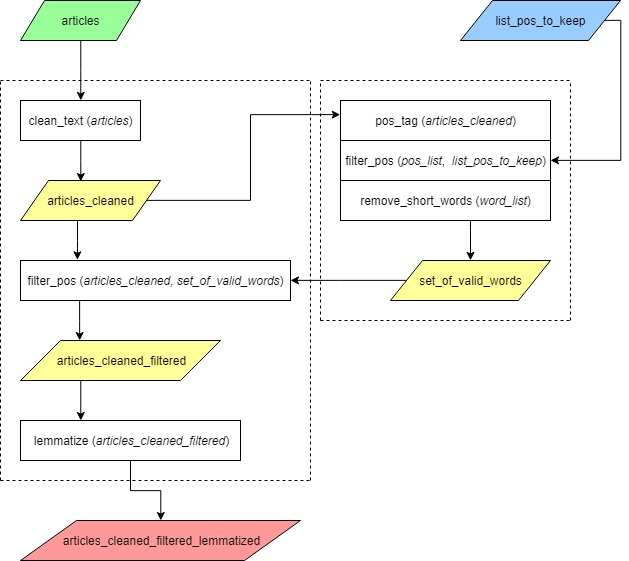

In [24]:
Image("../../reports/figures/TextCleaningPipeline_TopicModelling.jpg", width=600)

In [18]:
def filter_pos_from_word_list(pos_list, list_pos_to_keep):
    return [tuple_[0] for tuple_ in pos_list if tuple_[1] in list_pos_to_keep]

def text_filter(texts, list_pos_to_keep):
    merged_text = " ".join(texts.values.tolist())
    
    pos_list = pos_tag(word_tokenize(merged_text))
    
    word_list = filter_pos_from_word_list(pos_list, list_pos_to_keep)
    
    return [word for word in word_list if len(word) >= 4]

def filter_pos_from_text(text, set_valid_words):
    return " ".join([word for word in word_tokenize(text) if word in set_valid_words])

In [19]:
list_pos_to_keep = [
    "NN", "NNS", "NNP", "NNPS", 
    "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", 
    "JJ", "JJR", "JJS", "RB", "RBR", "RBS"
]

In [20]:
list_of_company_names = watchlist.index.tolist()

In [21]:
articles_cleaned = clean_text(articles, "title").title

valid_words = text_filter(articles_cleaned, list_pos_to_keep)

articles_final = (articles_cleaned.apply(filter_pos_from_text, args=(valid_words,))
                  .apply(lemmatize_text)
                  .apply(remove_company_name, args=(list_of_company_names,))
                 )

gridspecs:
https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0

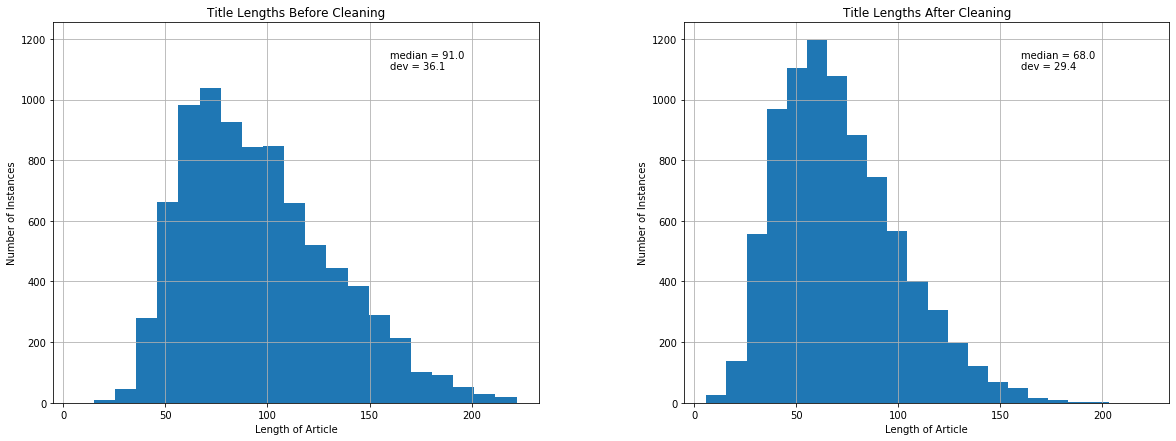

In [50]:
fig = plt.figure(figsize=(20,7))

gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig, width_ratios=[1, 1], wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0], title="Title Lengths Before Cleaning", xlabel="Length of Article", ylabel="Number of Instances")
ax1_text = "median = {}\ndev = {}".format(np.round(articles.title.apply(len).median(), 1), np.round(articles.title.apply(len).std(), 1))
ax1.text(160, 1100, ax1_text)
articles.title.apply(len).hist(bins=20, ax=ax1)

ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1, title="Title Lengths After Cleaning", xlabel="Length of Article", ylabel="Number of Instances")
ax2_text = "median = {}\ndev = {}".format(np.round(articles_final.apply(len).median(), 1), np.round(articles_final.apply(len).std(), 1))
ax2.text(160, 1100, ax2_text)
_ = articles_final.apply(len).hist(bins=20, ax=ax2)

### Run Through LDA Modelling

In [51]:
tokenized_titles_cleaned = [text.split(" ") for text in articles_final]
dictionary = corpora.Dictionary(tokenized_titles_cleaned)
dictionary.filter_extremes(no_below=5, no_above=0.4)

corpus = [dictionary.doc2bow(text) for text in tokenized_titles_cleaned]

tfidf_corpus = TfidfModel(corpus)[corpus]

In [55]:
# Settings
max_N = 15
min_N = 4

# Initialize result holder
cal_har_results = NumTopicsScoreHolder(calinski_harabasz_score, ">")

# Set the data to match formatting in SciKit Learn
num_docs = 8433
X = gensim.matutils.corpus2dense(tfidf_corpus, num_docs)

for model_n in range(min_N, max_N):
    lda_n = LdaModel(tfidf_corpus, model_n, passes=5, iterations=100)
    
    best_labels = get_best_labels(lda_n, tfidf_corpus)
    
    cal_har_results.update(X, lda_n, model_n, best_labels)

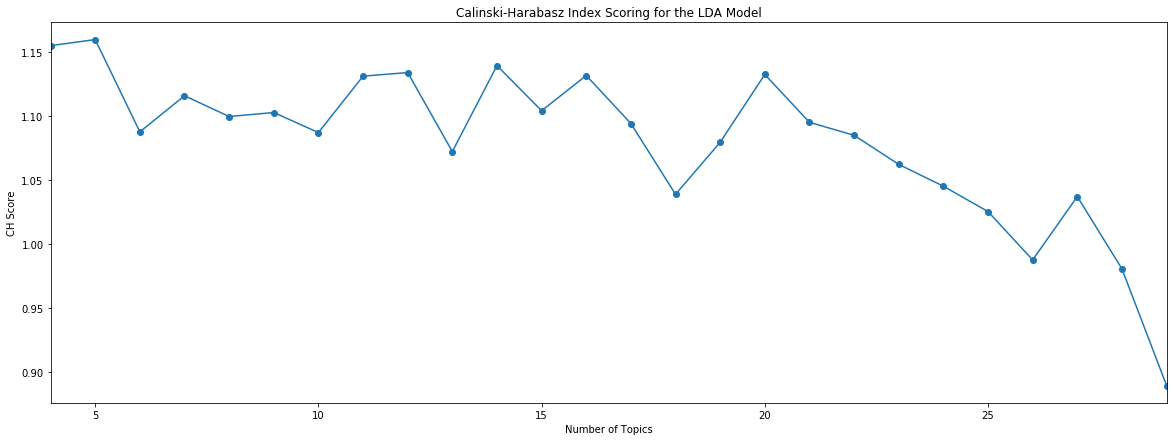

In [56]:
fig = plt.Figure(figsize=(20, 7))

ax = fig.add_subplot(title="Calinski-Harabasz Index Scoring for the LDA Model", xlabel="Number of Topics", ylabel="CH Score")

best_num = title=cal_har_results.get_best_model().num_topics

cal_har_results.score_df.score.plot(marker='o', ax=ax)

fig

In [57]:
pyLDAvis.gensim.prepare(cal_har_results.get_best_model(), tfidf_corpus, dictionary)

c:\users\michael\documents\projects and portfolio work\biopharmaceuticalfactormodel\venv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.174295 -0.039068       1        1  22.291729
3      0.164590  0.094915       2        1  21.402964
1      0.030456  0.067374       3        1  19.110432
4     -0.259622  0.162667       4        1  18.784567
0     -0.109719 -0.285889       5        1  18.410303, topic_info=     Category        Freq                Term       Total  loglift  logprob
38    Default  185.000000             quarter  185.000000  30.0000  30.0000
11    Default  200.000000              result  200.000000  29.0000  29.0000
36    Default  155.000000           financial  155.000000  28.0000  28.0000
33    Default  224.000000            pipeline  224.000000  27.0000  27.0000
142   Default  158.000000            investor  158.000000  26.0000  26.0000
37    Default  111.000000               first  111.000000  25.0000  25.0000
35    Default  189.000000              review  189.000000  24.0000  24.0000
42    Default   89.000000             appoint   89.000000  23.0000  23.0000
81    Default   87.000000                year   87.000000  22.0000  22.0000
59    Default   73.000000               chief   73.000000  21.0000  21.0000
79    Default   67.000000              fourth   67.000000  20.0000  20.0000
61    Default   74.000000             officer   74.000000  19.0000  19.0000
135   Default   81.000000               alert   81.000000  18.0000  18.0000
138   Default   71.000000               class   71.000000  17.0000  17.0000
105   Default   63.000000               third   63.000000  16.0000  16.0000
108   Default   72.000000               trial   72.000000  15.0000  15.0000
119   Default  314.000000              market  314.000000  14.0000  14.0000
322   Default  172.000000            forecast  172.000000  13.0000  13.0000
9     Default   69.000000               phase   69.000000  12.0000  12.0000
179   Default   58.000000            security   58.000000  11.0000  11.0000
134   Default   71.000000              action   71.000000  10.0000  10.0000
43    Default   97.000000               board   97.000000   9.0000   9.0000
45    Default   92.000000            director   92.000000   8.0000   8.0000
157   Default   88.000000                firm   88.000000   7.0000   7.0000
428   Default   90.000000               trend   90.000000   6.0000   6.0000
34    Default  254.000000  researchandmarkets  254.000000   5.0000   5.0000
156   Default   55.000000                file   55.000000   4.0000   4.0000
39    Default  238.000000              report  238.000000   3.0000   3.0000
31    Default  120.000000             insight  120.000000   2.0000   2.0000
195   Default   61.000000              update   61.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
1723   Topic5   21.776812                vnda   22.585102   1.6558  -5.1602
183    Topic5   33.924789         shareholder   35.255127   1.6538  -4.7169
274    Topic5   22.795177                 add   23.714230   1.6527  -5.1145
156    Topic5   52.816502                file   55.290150   1.6465  -4.2742
1518   Topic5   16.582470          huntington   17.362236   1.6463  -5.4327
809    Topic5   16.381094            software   17.154173   1.6461  -5.4449
1726   Topic5   18.879478                xent   19.771873   1.6461  -5.3030
143    Topic5   48.941757             lawsuit   51.373016   1.6438  -4.3504
1364   Topic5   15.902294           synthetic   16.705786   1.6430  -5.4746
1731   Topic5   25.758368                zgnx   27.077793   1.6423  -4.9923
1102   Topic5   15.361054       schizophrenia   16.148083   1.6423  -5.5092
242    Topic5   43.602825            upcoming   45.855396   1.6419  -4.4659
210    Topic5   22.735147         participate   23.914587   1.6417  -5.1171
1033   Topic5   14.348763             biology   15.116921   1.6401  -5.5774
1295   Topic5   20.286625           carcinoma   21.418816   1.6380  -5.2311
1123   

In [84]:
def get_top_n_words_in_topic(model, topic, gensim_dict, topn=10):
    return [gensim_dict[tuple_[0]] for tuple_ in model.get_topic_terms(topic, topn)]

In [103]:
best_model = cal_har_results.get_best_model()

num_topics = best_model.num_topics
num_keywords = 10

top_words_df = pd.DataFrame({"topic_{}".format(n+1): get_top_n_words_in_topic(best_model, n, dictionary, num_keywords) for
                             n in range(num_topics)}, index=[i for i in range(num_keywords)])

print("Top {} Keywords for Each Topic".format(num_keywords))
top_words_df

Top 10 Keywords for Each Topic


,topic_1,topic_2,topic_3,topic_4,topic_5
0,investor,appoint,market,pipeline,quarter
1,announce,chief,researchandmarkets,review,result
2,alert,officer,forecast,market,financial
3,conference,board,analysis,insight,report
4,present,director,trend,researchandmarkets,first
5,class,market,application,drug,year
6,action,murray,product,trial,announce
7,firm,glancy,xencor,profile,fourth
8,security,prongay,outlook,phase,third
9,file,therapeutic,type,report,update


In [104]:
words_in_multiple_topics = top_words_df.stack().value_counts().loc[top_words_df.stack().value_counts() > 1].index.tolist()

print(*words_in_multiple_topics)

market researchandmarkets report announce
